# Same as the Scikit-Learn version but with Keras

In [118]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error



HOUSING_PATH = os.path.join("..", "datasets", "housing")


In [119]:

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [120]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [121]:
housing.shape

(20640, 10)

In [122]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [123]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [124]:
y = housing['median_house_value']
X = housing.drop(columns=['median_house_value'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [125]:
X_train.shape

(16512, 9)

In [126]:
X_test.shape

(4128, 9)

In [127]:

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



In [128]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [129]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
#         ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])



In [130]:
list(X_train.columns)[:-1]

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [131]:
num_attribs = list(X_train.columns)[:-1]
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(X_train)

In [132]:
housing_prepared

array([[ 0.63622458, -0.74716147,  1.69573748, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79097277, -0.88288883, -0.52938104, ...,  0.        ,
         0.        ,  0.        ],
       [-1.10594049,  0.81604329, -0.52938104, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.11592425,  1.10153877, -0.84725511, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89128978,  1.11089927, -1.00619215, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26682568, -0.1059667 , -0.68831807, ...,  0.        ,
         0.        ,  0.        ]])

In [133]:
housing_prepared.shape

(16512, 16)

In [134]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [135]:
model = build_model(housing_prepared.shape[1])

In [136]:
epochs_hist = model.fit(housing_prepared, y_train.values, epochs=120, batch_size=25,  verbose=1, validation_split=0.2)


Train on 13209 samples, validate on 3303 samples
Epoch 1/120
13209/13209 [==============================] - 1s 102us/sample - loss: 23372985708.0766 - val_loss: 6221154374.7139
Epoch 2/120
13209/13209 [==============================] - 1s 62us/sample - loss: 5391660209.1108 - val_loss: 4983866970.7442
Epoch 3/120
13209/13209 [==============================] - 1s 63us/sample - loss: 4707581278.7330 - val_loss: 4706700678.7623
Epoch 4/120
13209/13209 [==============================] - 1s 63us/sample - loss: 4469144846.3320 - val_loss: 4560827451.2140
Epoch 5/120
13209/13209 [==============================] - 1s 61us/sample - loss: 4345626748.1965 - val_loss: 4485481997.6797
Epoch 6/120
13209/13209 [==============================] - 1s 61us/sample - loss: 4281966382.0195 - val_loss: 4413259314.5916
Epoch 7/120
13209/13209 [==============================] - 1s 61us/sample - loss: 4247121658.4716 - val_loss: 4411658814.1496
Epoch 8/120
13209/13209 [==============================] - 1s 60us/

13209/13209 [==============================] - 1s 65us/sample - loss: 3078655868.8845 - val_loss: 3303653674.4099
Epoch 66/120
13209/13209 [==============================] - 1s 64us/sample - loss: 3099127522.8417 - val_loss: 3334706139.1293
Epoch 67/120
13209/13209 [==============================] - 1s 65us/sample - loss: 3097171083.9095 - val_loss: 3281686664.5207
Epoch 68/120
13209/13209 [==============================] - 1s 64us/sample - loss: 3073616982.2491 - val_loss: 3312653229.8395
Epoch 69/120
13209/13209 [==============================] - 1s 70us/sample - loss: 3048812818.1064 - val_loss: 3254438180.0448
Epoch 70/120
13209/13209 [==============================] - 1s 66us/sample - loss: 3047101113.9484 - val_loss: 3406137972.8078
Epoch 71/120
13209/13209 [==============================] - 1s 69us/sample - loss: 3041895316.6380 - val_loss: 3263644249.0148
Epoch 72/120
13209/13209 [==============================] - 1s 70us/sample - loss: 3025007614.2218 - val_loss: 3243536354.70

In [137]:
np.sqrt(3076091411.4538)

55462.52258465892

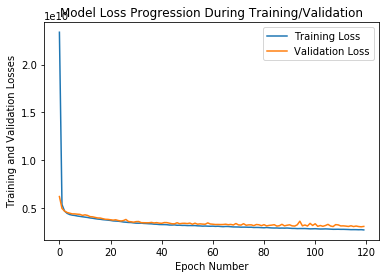

In [138]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])


In [139]:
X_test.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [140]:
X_test_prepared = full_pipeline.transform(X_test)

In [141]:
X_test_prepared

array([[ 0.54137892, -0.56931183, -0.44991252, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70611086, -0.87352832,  0.10636711, ...,  0.        ,
         0.        ,  1.        ],
       [-1.125908  ,  0.460344  ,  0.34477267, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.47533939,  1.09217826,  1.85467452, ...,  0.        ,
         1.        ,  0.        ],
       [-0.82639538,  1.0172942 , -1.00619215, ...,  0.        ,
         0.        ,  0.        ],
       [-0.84137101,  1.07345724,  0.34477267, ...,  0.        ,
         0.        ,  0.        ]])

In [142]:
predictions = model.predict(X_test_prepared)

In [143]:
predictions.shape

(4128, 1)

In [144]:
y_test.shape

(4128,)

In [145]:
rmse = np.sqrt(mean_squared_error(predictions, y_test))

In [146]:
rmse

54972.51991759191

without the combined column

rmse: 53662.66651125556

with the combined column transformer:

rmse: 54972.51991759191


In [147]:
from scipy import stats

confidence = 0.95
squared_errors = (predictions - np.expand_dims(y_test, 1)) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([[52621.11963891],
       [57227.3855783 ]])